In [27]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import PartialDependenceDisplay
import math

'''The point of this section is to A) import the dataset, B) drop unecessary columns (assuming you need to), C) rename columns (if you want),
and then D) adjust data types.'''


#Load the dataset. Atlanta_Nearest_Distances.csv is the dataset being used. It is essentially a placeholder. 
#It is also assuming this is a LOCAL file that was downloaded directly to the computer, hence the location. This can be replaced with anything, like a git location. 
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv') 

#Combine redundant columns. The two baths columns are addressing the same overall feature, they can be combined into "total baths", like "total bedrooms". 
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)

#Drop any columns you aren't analyzing.
Atlanta_Distance = Atlanta_Distance.drop(columns=['latitude',
                                                  'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths',
                                                  	 'has_pool', 'has_garage', 'number_of_garage_spaces', 'listing_date', 'number_of_stories', 'lot_size_in_square_feet',
                                                 'Supercenter_POI', 'Convenience_POI', 'Supermarket_POI', 'Wholesale_POI', 'Variety_Store_POI', 'story_indicator'])

#Rename columns for clarity. 
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                'year_built': 'Year Built'})

#"Year built" is read as a float OR as a string, it should be read as an integer. For numerical analysis, use int or float if there are missing values, which "year built" has.
Atlanta_Distance['Year Built'] = Atlanta_Distance['Year Built'].astype('Int64')
Atlanta_Distance

,street_address,current_listing_price,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,0 ivy MNR DR NW 0,2865,2002,4,3259.0,10917.45,6405.99,1654.08,2539.28,2715.74,2.5
1,1 10 buena VIS CIR SE,2200,<NA>,3,1993.0,32739.68,405.11,3065.55,492.63,1407.26,2.0
2,1 1088 coldwater DR,2000,<NA>,3,1910.0,29267.11,4738.04,3780.13,25413.80,3213.19,2.0
3,1 1130 willivee DR,1995,<NA>,3,1134.0,9020.53,4356.55,2320.59,7857.71,2385.60,1.0
4,1 1307 idlewood CT,2800,<NA>,4,2532.0,14750.79,6721.22,5625.35,11676.91,14263.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...
21010,procurement only - 66 4th ST,1600,<NA>,3,1367.0,47285.12,6409.21,2097.35,19852.16,4983.93,2.0
21011,r2188 executive DR,2199,<NA>,3,1696.0,2009.36,6142.54,888.22,4864.86,1477.04,2.5
21012,r3339 woodward down,2380,2015,3,1944.0,1507.23,714.63,1158.08,1359.41,3952.51,3.5
21013,singleunit 216 greensprings DR,1900,<NA>,4,1204.0,40632.51,1402.52,8779.81,10787.35,1242.13,2.0


In [28]:
'''We now want to create a pipeline for the dataset, focusing on the numeric features. We begin by selecting just the numeric features, applying a scaler transformer,
and then merging that into a preprocessor'''


# Exclude 'current_listing_price' from features, since this is your target
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean (you may also do median)
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric. The preprocessor applies the transformer (filling in the means and scaling the data) to the numeric features. This prevents data leakage
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
])

#Apply preprocessor to original data (this isn't really necessary for this model, but can be useful for others like the MLR) 
transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [29]:
# Create a list from the numeric features to check if columns were selected correctly.
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

In [30]:
#Create a dataframe from the applied preprocessor with the list to see the results. This is "technically" not necessary, only if you need to see the data itself.
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,5.031097e-01,0.641662,1.314310,-0.636824,0.541928,-0.543506,-0.853198,-0.558318,0.177326
1,-1.091762e-14,-0.459475,0.111774,1.494518,-1.156558,-0.087041,-1.210471,-0.973399,-0.475680
2,-1.091762e-14,-0.459475,0.032935,1.155358,0.069832,0.144052,3.139891,-0.400516,-0.475680
3,-1.091762e-14,-0.459475,-0.704165,-0.822093,-0.038145,-0.327959,0.075214,-0.663046,-1.781691
4,-1.091762e-14,0.641662,0.623754,-0.262428,0.631150,0.740791,0.741912,3.104812,-0.475680
...,...,...,...,...,...,...,...,...,...
21010,-1.091762e-14,-0.459475,-0.482845,2.915148,0.542839,-0.400154,2.169024,0.161205,-0.475680
21011,-1.091762e-14,-0.459475,-0.170338,-1.506863,0.467361,-0.791183,-0.447233,-0.951263,0.177326
21012,1.127320e+00,-0.459475,0.065230,-1.555905,-1.068952,-0.703911,-1.059161,-0.165986,1.483337
21013,-1.091762e-14,0.641662,-0.637674,2.265398,-0.874252,1.760934,0.586626,-1.025782,-0.475680


In [31]:
'''Next is to create the initial model. This model calls for a train-test-validation split, also called a three-way split. First, the model needs to be defined and
put into the pipeline. Then, the split needs to be defined. This is explained in detail in the code. After this is done, the pipeline should be fit on the training set.'''

xgb_model = XGBRegressor(random_state=42)
# Define the full model pipeline including the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

#1. Split the dataset into a train set and a test set.
#2. Split the training data further into a training set and a validation set.
#3. Use the validation set for tuning, then assess performance on the test set.

X = Atlanta_Distance.drop(columns='current_listing_price')
y = Atlanta_Distance['current_listing_price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #This splits your data into 80% (X_train_val) and 20% (X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) #X_train_val data is further split into 60% train set (X_train) and 20% validation (X_val)
#Note: the test_size=0.25 is used to split the remaining training and validation set into 75% training and 25% validation (75% of 80% = 60%)
pipeline.fit(X_train, y_train) #The pipeline is fit on the training data and evaluated on the validation set (X_val)


#Test Set (X_test): This set is a held-out portion of the data that the model has never seen during training or tuning, making it the best indicator of the model's generalization performance. The test score tells you how well the model is likely to perform on truly unseen data, which is typically the main goal.

#Validation Set (X_val): The validation set is primarily used during model selection and hyperparameter tuning. It gives a good intermediate measure of model performance, but since it has influenced model tuning, it can no longer be considered a truly unbiased assessment of generalization.

#Combined Train-Validation Set (X_train_val): This set is used for final training once the best model has been selected. While scores on this set give an idea of how well the model fits on a larger amount of data, they do not represent true generalization performance, as the data has been used for model tuning and training.

#Training Set (X_train): The training set score can help diagnose underfitting or overfitting during development, but it isn’t relevant as a final evaluation metric because it doesn’t measure how well the model generalizes.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_score=None...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [32]:
'''We then "can" calculate the R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Percentage Error for the default sets.'''

#This is the cross-validation score. A higher R^2 usually means a better model.
#The goal is to have the test score be as close to the train-val score as possible. This score can be used to compare your future model against, but, 
#unless specified, only a tuned model would be preferred since that is supposed to have a higher score
val_score = pipeline.score(X_val, y_val)
print('Validation R^2:', val_score)

test_score = pipeline.score(X_test, y_test)
print('Test R^2:', test_score)

Validation R^2: 0.5828113555908203
Test R^2: 0.5887373685836792


In [33]:
#This is how you would manually calculate the Mean Squared Error without using some kind of function, using "predict".
y_val_pred = pipeline.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 348029.3331461368
Validation Root Mean Squared Error: 589.9401097960172
Test Mean Squared Error: 351261.6801554851
Test Root Mean Squared Error: 592.6733334270111


In [34]:
#You can calculate MAPE using a function, which then borrows the same variables from the MSE. 
def calculate_mape(actual, predicted):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between actual and predicted values.

    MAPE is a metric that expresses the prediction error as a percentage of the actual values. 
    It is calculated by taking the average of the absolute percentage differences between the 
    actual and predicted values.

    Parameters:
    ----------
    actual : array-like
        The true values or ground truth.
    predicted : array-like
        The predicted values from the model.

    Returns:
    -------
    float
        The MAPE value, representing the average percentage error. Lower values indicate better 
        model performance. A perfect score is 0.0, while higher values indicate greater error.
    """
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 15.140242970201923
Test Mean Absolute Percentage Error (MAPE): 15.269312336827937


In [35]:
'''Hyperparameter tuning is used to improve the scores of the default values. First, a grid, or layout, must be created for your model.
Then, you can actually combine all the scoring into one "gridsearch", which is the method we'll use to tune. It is more efficient, but slower than randomized searching.'''


# Create a StratifiedKFold object. This is used for cross-validation, taking into account randomization. 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Define the parameter grid
#Regularization: Adjusting alpha and lambda in XGBoost to penalize overly complex models.
#Simplify the Model: Reduce the complexity of the model by lowering the max_depth of trees and reducing the number of estimators.

param_grid = {
    'regressor__n_estimators': [400],          # The number of boosting rounds or trees. Higher values may improve model performance but also increase training time. 
    'regressor__learning_rate': [0.05],        # Controls the impact of each boosting round on the final model. Lower values make learning more gradual and can improve accuracy, though may require more trees.
    'regressor__max_depth': [4],               # Maximum depth of each tree. Limits complexity; lower values reduce overfitting, while higher values can capture more complex patterns.
    'regressor__subsample': [0.8],             # Fraction of the training data used per boosting round. Values below 1.0 can prevent overfitting by introducing randomness.
    'regressor__colsample_bytree': [0.8],      # Fraction of features sampled to train each tree. Lower values prevent overfitting by adding randomness, which can improve generalization.
    'regressor__alpha': [20],                  # L1 regularization term on weights, similar to Lasso regression. Helps to make the model simpler by forcing some feature weights to be zero, reducing overfitting.
    'regressor__lambda': [20]                  # L2 regularization term on weights, similar to Ridge regression. Helps to make the model more stable and reduces overfitting.
}

# Multi-scoring in GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],  # Multiple scoring
    refit='r2',  # Specify which metric to refit. R2 is used by default.
    cv=kf,
    n_jobs=-1, #This just uses all of your computer's processing power. 
    verbose=2 #This is logging information
)
grid_search.fit(X_train, y_train) #Literally the equivalent of pipeline.fit, but now we're working with a grid_search

best_model = grid_search.best_estimator_ #Best_model is technically irrelevant because there are no other options. This model already narrowed down what the best model was.

# These are just the "highest" results. It's not the validation set. 
results = grid_search.cv_results_
print("Best parameters:", grid_search.best_params_)
print("Best R^2:", grid_search.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 20, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 20, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Best R^2: 0.5627784430980682


In [36]:
def calculate_scores(y_true, y_pred):
    """
    Calculate and return multiple regression evaluation metrics.

    This function computes the R² score, Mean Squared Error (MSE), 
    Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) 
    for a set of true values and predicted values, providing a comprehensive 
    evaluation of model performance.

    Parameters:
    ----------
    y_true : array-like
        The true target values.
    y_pred : array-like
        The predicted target values from the model.

    Returns:
    -------
    tuple
        A tuple containing the following scores:
        - r2 : float : R² score, indicating the proportion of variance explained by the model.
        - mse : float : Mean Squared Error, measuring the average squared difference between 
          the predicted and actual values.
        - mape : float : Mean Absolute Percentage Error, showing the average percentage error.
        - rmse : float : Root Mean Squared Error, providing an interpretable measure of 
          prediction error in the original units of the target variable.
    """
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return r2, mse, mape, rmse

In [37]:
'''We now want to create a method to calculate the scores for every set.
Using the previous function, we merely use it against each version of "best model" predicted against each set.'''

#Applies the function to the val set
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

#Applies the function to the test set
y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

#Applies the function to the train-val set
y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_train_val, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")
#Refitted model may be causing data leakage, and therefore different results. Differences can be ignored

Tuned Validation Set Scores:
R²: 0.5676
MSE: 360701.0136
MAPE: 0.1536
RMSE: 600.5839

Tuned Test Set Scores:
R²: 0.5577
MSE: 377794.2855
MAPE: 0.1554
RMSE: 614.6497

Tuned Train-Val Set Scores:
R²: 0.6408
MSE: 296165.2733
MAPE: 0.1435
RMSE: 544.2107


In [38]:
'''The next step is to create an identifier for feature importance, usually done through a graph. 
You would take the "best model" and all of its feature names, sort it, and then extract the importance.'''

#This is technically redundant, but what it's technically recalling the best model from the pipeline.
best_xgb_model = best_model.named_steps['regressor']

#This is getting the feature importances from the best model
feature_importances = best_xgb_model.feature_importances_

#You first sort the feature importances in descending order, then you turn it into an array.
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

#This function allows for naming and rounding of the features and the listed importances.
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Total Bathrooms, Importance: 0.3250
Feature: Living Area(SQF), Importance: 0.2551
Feature: Total Bedrooms, Importance: 0.0771
Feature: Wholesale, Importance: 0.0725
Feature: Year Built, Importance: 0.0692
Feature: Supermarket, Importance: 0.0637
Feature: Supercenter, Importance: 0.0585
Feature: Convenience, Importance: 0.0479
Feature: Variety Store, Importance: 0.0310


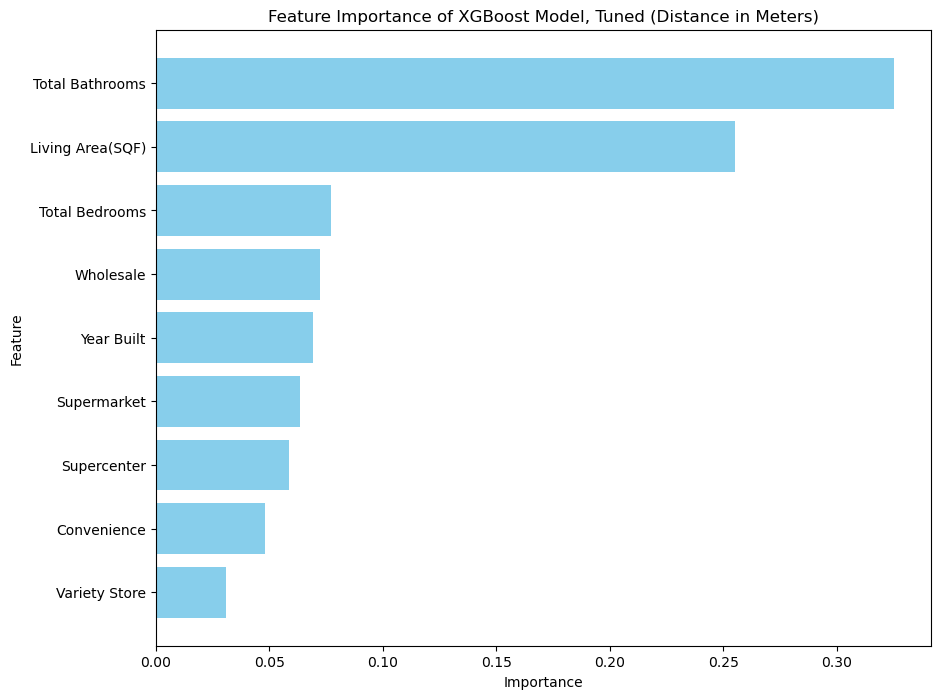

In [39]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the train, test, or train-val set. 

In [40]:
all_feature_names #Redundant, but but was called as a reminder for the next step. 

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

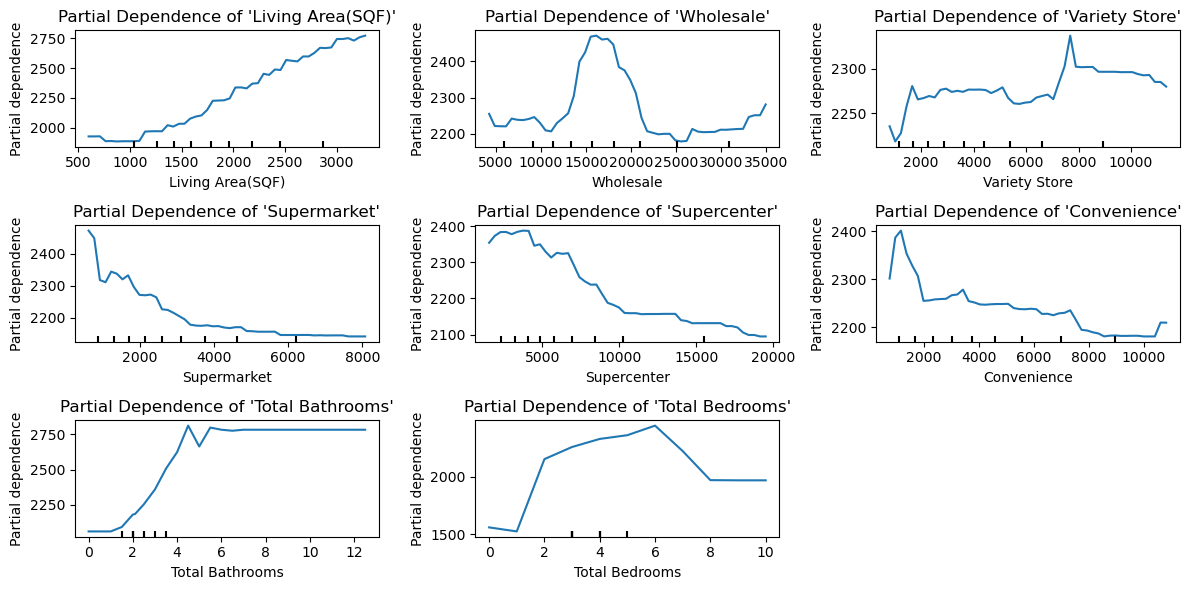

In [41]:
"""
Generates Partial Dependence Plots (PDPs) for specified features to visualize their effect on the model’s predictions. 
Each plot shows the marginal relationship between a feature and the predicted outcome, with all other features averaged out. 
Useful for understanding how changes in individual features impact the model’s predictions.

Parameters:
- best_model: The trained model object from which to generate the PDPs.
- X_train_val: The training (or training-validation) dataset containing feature columns.
- features: A list of feature names (as strings) for which to generate PDPs.
"""

# List of features to include in the Partial Dependence Plots
features = [
    'Living Area(SQF)', 'Wholesale', 'Variety Store', 'Supermarket', 
    'Supercenter', 'Convenience', 'Total Bathrooms', 'Total Bedrooms'
]

# Set up the grid layout based on the number of features
n_features = len(features)  # Total number of features to plot
n_cols = 3  # Number of columns in the grid layout
n_rows = math.ceil(n_features / n_cols)  # Calculate number of rows needed

# Create a figure with subplots arranged in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))
axes = axes.ravel()  # Flatten the axes array to simplify indexing

# Loop through each feature and generate a PDP on a subplot
for i, feature in enumerate(features):
    # Generate the Partial Dependence Plot for the current feature
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train_val,  # Use the training dataset (or training-validation) for PDP
        [feature],
        grid_resolution=50,  # Resolution of the grid for smoothness of the PDP
        ax=axes[i]  # Place the plot on the specified subplot axis
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set a title for each plot

# Hide any empty subplots if the grid is larger than the number of features
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure subplots do not overlap and labels are clear
plt.tight_layout()
plt.show()

In [42]:
"""
The following is an attempt to extract the scores form the baseline model. A baseline is all independent variables except any variables that were added 
as part of the project. In this case, that would be anything related to the grocery stores. "b" literally represents baseline.
The outline for everything is otherwise identical. 
"""

Atlanta_Distance_b = Atlanta_Distance.drop(columns=['Wholesale','Variety Store','Supermarket','Supercenter','Convenience'])
Atlanta_Distance_b = Atlanta_Distance_b.groupby(["street_address"])[['Year Built','Total Bedrooms','Living Area(SQF)','Total Bathrooms', 'current_listing_price']].max().reset_index(drop = False)
Atlanta_Distance_b

,street_address,Year Built,Total Bedrooms,Living Area(SQF),Total Bathrooms,current_listing_price
0,0 ivy MNR DR NW 0,2002,4,3259.0,2.5,2865
1,1 10 buena VIS CIR SE,<NA>,3,1993.0,2.0,2200
2,1 1088 coldwater DR,<NA>,3,1910.0,2.0,2000
3,1 1130 willivee DR,<NA>,3,1134.0,1.0,1995
4,1 1307 idlewood CT,<NA>,4,2532.0,2.0,2800
...,...,...,...,...,...,...
19213,procurement only - 66 4th ST,<NA>,3,1367.0,2.0,1600
19214,r2188 executive DR,<NA>,3,1696.0,2.5,2199
19215,r3339 woodward down,2015,3,1944.0,3.5,2380
19216,singleunit 216 greensprings DR,<NA>,4,1204.0,2.0,1900


In [43]:
numeric_features_b = Atlanta_Distance_b.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

#We don't have to do anything additional with the preprocessor since that was already done for us in the distance model. The only thing different is the number of features.
preprocessor_b = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_b),
])
transformed_data_b = preprocessor_b.fit_transform(Atlanta_Distance_b)
all_feature_names_b = list(numeric_features_b)
transformed_df_b = pd.DataFrame(transformed_data_b, columns=all_feature_names_b)
transformed_df_b

,Year Built,Total Bedrooms,Living Area(SQF),Total Bathrooms
0,5.068264e-01,0.670187,1.319220,0.189453
1,1.073134e-14,-0.440415,0.101174,-0.465279
2,1.073134e-14,-0.440415,0.021318,-0.465279
3,1.073134e-14,-0.440415,-0.725288,-1.774741
4,1.073134e-14,0.670187,0.619757,-0.465279
...,...,...,...,...
19213,1.073134e-14,-0.440415,-0.501114,-0.465279
19214,1.073134e-14,-0.440415,-0.184576,0.189453
19215,1.120386e+00,-0.440415,0.054030,1.498915
19216,1.073134e-14,0.670187,-0.657940,-0.465279


In [44]:
#The model is technically the same, but it was repeated for clarity.
xgb_model = XGBRegressor(random_state=42)
pipeline_b = Pipeline([
    ('preprocessor', preprocessor_b),
    ('regressor', xgb_model)
])

#Everything has to have a new variable and be refitted because it's now being applied to a "new" set of features. 
X_b = Atlanta_Distance_b.drop(columns='current_listing_price')
y_b = Atlanta_Distance_b['current_listing_price']
X_train_val_b, X_test_b, y_train_val_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_val_b, y_train_val_b, test_size=0.25, random_state=42)
pipeline_b.fit(X_train_b, y_train_b)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Total Bathrooms'], dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [45]:
val_score_b = pipeline_b.score(X_val_b, y_val_b) 
print('Validation R^2:', val_score_b)

test_score_b = pipeline_b.score(X_test_b, y_test_b) 
print('Test R^2:', test_score_b)

Validation R^2: 0.38495951890945435
Test R^2: 0.4431343078613281


In [46]:
#The parameters need to be adjusted because of the new score. This was determined to be optimal. 
param_grid_b = {
    'regressor__n_estimators': [200],
    'regressor__learning_rate': [0.05],
    'regressor__max_depth': [6],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__alpha': [10],
    'regressor__lambda': [10]
}


grid_search_b = GridSearchCV(
    estimator=pipeline_b,
    param_grid=param_grid_b,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],  # Multiple scoring
    refit='r2',  # Specify which metric to refit
    cv=kf,
    n_jobs=-1,
    verbose=2
)


grid_search_b.fit(X_train_b, y_train_b)

best_model_b = grid_search_b.best_estimator_

# Access the results
results_b = grid_search_b.cv_results_
print("Best parameters:", grid_search_b.best_params_)
print("Best R^2:", grid_search_b.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 10, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best R^2: 0.408859384059906


In [47]:
y_val_pred_tuned_b = best_model_b.predict(X_val_b)
val_scores_b = calculate_scores(y_val_b, y_val_pred_tuned_b)

y_test_pred_tuned_b = best_model_b.predict(X_test_b)
test_scores_b= calculate_scores(y_test_b, y_test_pred_tuned_b)

y_combined_pred_tuned_b = best_model_b.predict(X_train_val_b)
combined_scores_b = calculate_scores(y_train_val_b, y_combined_pred_tuned_b)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_b[0]:.4f}")
print(f"MSE: {val_scores_b[1]:.4f}")
print(f"MAPE: {val_scores_b[2]:.4f}")
print(f"RMSE: {val_scores_b[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_b[0]:.4f}")
print(f"MSE: {test_scores_b[1]:.4f}")
print(f"MAPE: {test_scores_b[2]:.4f}")
print(f"RMSE: {test_scores_b[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_b[0]:.4f}")
print(f"MSE: {combined_scores_b[1]:.4f}")
print(f"MAPE: {combined_scores_b[2]:.4f}")
print(f"RMSE: {combined_scores_b[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.4230
MSE: 539501.9158
MAPE: 0.1741
RMSE: 734.5079

Tuned Test Set Scores:
R²: 0.4779
MSE: 439828.0931
MAPE: 0.1694
RMSE: 663.1954

Tuned Train-Val Set Scores:
R²: 0.5080
MSE: 404398.7268
MAPE: 0.1628
RMSE: 635.9235


In [48]:
best_xgb_model_b = best_model_b.named_steps['regressor']
feature_importances_b = best_xgb_model_b.feature_importances_
sorted_indices_b = np.argsort(feature_importances_b)[::-1]
sorted_feature_importances_b = feature_importances_b[sorted_indices_b]
sorted_feature_names_b = np.array(all_feature_names_b)[sorted_indices_b]
for name, importance in zip(sorted_feature_names_b, sorted_feature_importances_b):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.4078
Feature: Total Bathrooms, Importance: 0.3188
Feature: Year Built, Importance: 0.1453
Feature: Total Bedrooms, Importance: 0.1280


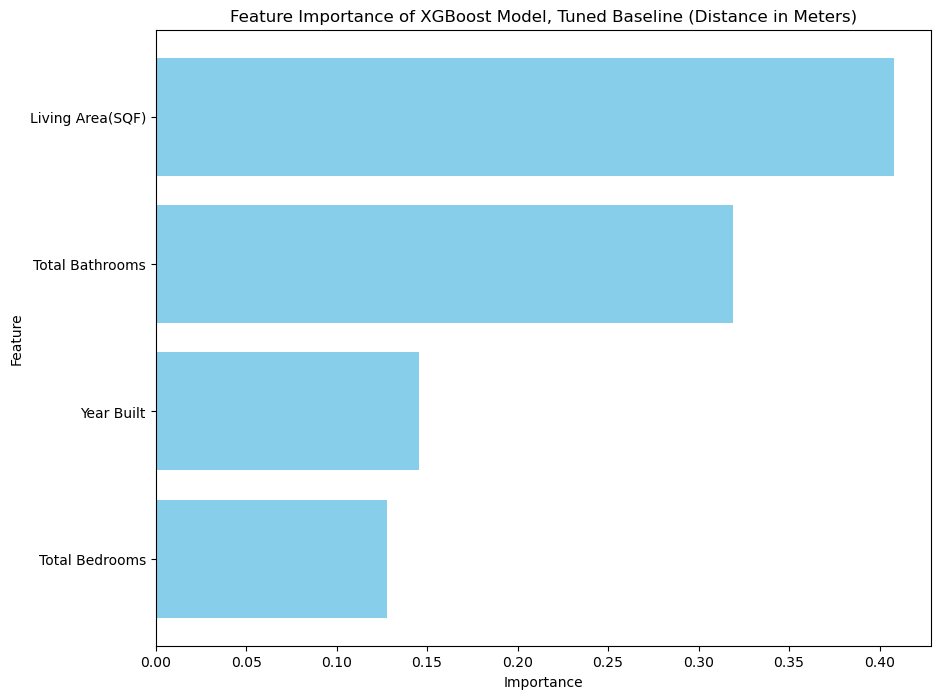

In [49]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_b, sorted_feature_importances_b, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned Baseline (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

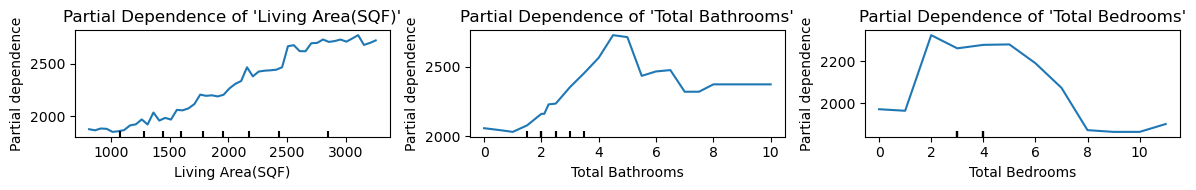

In [50]:
#Make sure the correct features are selected. Year built cannot be selected due to issues with NAN values. 
features = [
    'Living Area(SQF)', 'Total Bathrooms', 'Total Bedrooms'
]

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_b,
        X_train_val_b, 
        [feature],
        grid_resolution=50,
        ax=axes[i]  # Place in the correct subplot
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()